# 전체 코드 정리

## 라이브러리 설치

In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
# !pip install soynlp
# !pip install nltk
# !pip install konlpy
# !pip install haversine
# !pip install transformers
# !pip install sentencepiece
# !pip install tqdm
# # !pip install fasttext_wheel
# !pip install koreanize-matplotlib
# !pip install gensim
# !pip install imblearn
# !pip install imbalanced-learn
# !pip install fastapi uvicorn
# !pip install wordcloud
# !pip install sklearn
# !pip install pandas
# !pip install openpyxl

# !pip install torch torchvision torchaudio
# !pip install --ignore-installed torch
# !pip install chromadb

In [2]:
# !pip install scipy==1.10.1

In [3]:
# # 맞춤법 교정 bert - 성능 안좋음 - LLM 모델 사용 하기 

# import torch
# from transformers import BertTokenizer, BertForMaskedLM
# from konlpy.tag import Okt

# # BERT 모델과 토크나이저 로드
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased')

# # 문장을 BERT 모델로 교정하는 함수
# def correct_spelling(sentence):
#     inputs = tokenizer.encode(sentence, return_tensors='pt')
#     with torch.no_grad():
#         outputs = model(inputs)
#     predictions = outputs[0]
    
#     corrected_sentence = tokenizer.decode(torch.argmax(predictions, dim=-1)[0])
#     return corrected_sentence.replace('[CLS] ', '').replace(' [SEP]', '').replace('[PAD]', '').strip()


## 라이브러리 임포트

In [2]:
import pandas as pd
import numpy as np
import re
import joblib
import io
from itertools import chain
from collections import Counter

# 맞춤법검사 PLM 관련
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, pipeline

# 전처리 관련
from pykospacing import Spacing # 띄어쓰기 교정
from soynlp.normalizer import emoticon_normalize  # 반복 단어 제거
from konlpy.tag import Okt  # 품사 태깅

# 모델 부분 관련
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

# VectorDB 관련
import chromadb
from chromadb.config import Settings

# 시각화 관련
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import base64




## 함수 정리

In [3]:
# 맞춤법 교정 모델 text2text GAN (Pretrained Language Model : PLM 모델 활용)
corrector_model = T5ForConditionalGeneration.from_pretrained('j5ng/et5-typos-corrector')
corrector_tokenizer = T5Tokenizer.from_pretrained('j5ng/et5-typos-corrector')

typos_corrector = pipeline(
    "text2text-generation",
    model=corrector_model,
    tokenizer=corrector_tokenizer,
    device='cpu',
    framework="pt",
)

# 맞춤법 교정
def spelling_check(text):
    """
    맞춤법 교정
    """
    # 텍스트를 문장 단위로 분할합니다.
    parts_of_text = re.split(r'([,.!?])', text)  # 구분자를 유지하기 위해 그룹화

    correct_text = []

    for i in range(0, len(parts_of_text), 2):
        sentence = parts_of_text[i]
        if sentence.strip():  # 문장이 비어있지 않은 경우에만 처리
            # 맞춤법 교정을 적용합니다.
            corrected = typos_corrector("맞춤법을 고쳐주세요: " + sentence,
                                        max_length=128,
                                        num_beams=5,
                                        early_stopping=True)[0]['generated_text']
            corrected = corrected.rstrip('.,!?')
            correct_text.append(corrected)
        
        # 구분자(특수문자)를 다시 추가합니다.
        if i + 1 < len(parts_of_text):
            correct_text.append(parts_of_text[i + 1])

    return ''.join(correct_text)

# 띄어쓰기 처리
def spacing_processing(text):
    """
    띄어쓰기 처리
    """

    spacing = Spacing()
    text = spacing(text)
    return text

# 반복 문자 처리
def repetitive_character_processing(text):
    """
    반복 문자 처리
    """
    text = emoticon_normalize(text, num_repeats=2)
    return text


# 사용자 입력 데이터 처리
def input_process_text(text):
    text = repetitive_character_processing(text)
    text = spacing_processing(text)
    text = spelling_check(text)
    return text

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### 사용자 입력 데이터 예제

In [4]:
# 입력데이터 예제
user_input = '안녕하세요.어린이와 아이와 함께 저는오늘 숲쳬험학습, 체험프로그램을 예약하고싶슴니다.ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ'
print(f"사용자 입력 : {user_input} \n올바른 사용자 입력 : {input_process_text(user_input)}")

사용자 입력 : 안녕하세요.어린이와 아이와 함께 저는오늘 숲쳬험학습, 체험프로그램을 예약하고싶슴니다.ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ 
올바른 사용자 입력 : 안녕하세요.어린이와 아이와 함께 저는 오늘 숲 체험 학습,체험 프로그램을 예약하고 싶습니다.ᄒᄒ


## 키워드 추출 

In [5]:
# 한글이 아닌 특수문자 제거
def extract_keywords(text):

    # Konlpy
    okt = Okt()

    # 불용어처리
    stopwords = ['한테', '모레', '로', '나', '있다', '이미', '많이', '하다', '것', '종일', '매우', '하며', '있는', '곳', '저', '그것', '내일', '과', '그렇다면', '너',
                '누구의', '언제', '있고', '에서', '무엇', '정말', '와', '혹은', '이따가', '가', '그녀', '어제', '진짜', '실제로', '무슨', '만일', '가장', '등', '몹시',
                '께', '하지만', '을', '아주', '이', '누구', '그리고', '에게서', '잠깐', '모두', '에', '으로', '위한', '너무', '여기', '어디', '그러나', '의', '계속', '누가',
                '또는', '한참', '하고', '한테서', '우리', '이것', '까지', '조금', '그', '오늘', '적게', '그렇지만', '만약', '수', '를', '부터', '무엇이', '그래서', '는',
                '및', '방금', '은', '등등', '그런데', '거기', '어떤', '에게', '도', '벌써', '당신', '지금', '다', '저것', '할', '그냥', '사실', '어느', '얼마나', '읽을',
                '잠시', '어떻게', '한', '금방', '저기', '가득', '추천', '알려줘', '해줘', '어린이', '아이', '먹다', '맛', '가다', '오다', '자다', '같다', '더', '넘다', '또', 
                '이다', '아쉽다', '바', '꼭', '보다', '되어다', '나오다', '요', '들다', '처', '다음', '때', '되다', '거', '싶다', '점', '주다', '리지', '널', '크리스', '크림', 
                '피', '드', '안', '역시', '받다', '글레이', '좀', '꾸다', '지점', '해', '덮다', '집', '굿', '시', '비', '없다', '나다', '생기다', '바로', '못', '날']
    parts_of_text = re.split(r'([,.!?])', text)  # 구분자를 유지하기 위해 그룹화
    processed_tokens = []

    for part in parts_of_text:
        tokens = okt.pos(part.strip(), stem=True)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            # 명사, 형용사, 동사인 경우에만 처리
            if token[1] in ['Noun', 'Adjective', 'Verb'] and token[0] not in stopwords:
                processed_tokens.append(token[0])

                # 명사이거나 형용사인 경우 -> 명사 + 명사 : 복합명사 ex) 숲체험 / 형용사 + 명사 : 꾸며주는 명사 ex) 친절한 직원
                if token[1] in ['Noun', 'Adjective']:
                    # 다음 토큰도 명사이고, 두 토큰을 합쳐서 하나의 토큰으로 처리
                    if i < len(tokens) - 1 and tokens[i + 1][1] in ['Noun'] and tokens[i + 1][0] not in stopwords:
                        combined_token = token[0] + tokens[i + 1][0]
                        processed_tokens.append(combined_token)
                        # 형용사 + 명사 + 명사 또는 명사 + 명사 + 명사 인 경우 앞에 두개의 토큰을 더한 값은 삭제 후 새로운 토큰 삽입
                        # ex) 넓은 키즈카페, ex)문화예술회관
                        if i < len(tokens) - 2 and tokens[i + 2][1] in ['Noun'] and tokens[i + 2][0] not in stopwords:
                            combined_token = token[0] + tokens[i + 1][0] + tokens[i + 2][0]
                            processed_tokens.pop(-1)
                            processed_tokens.append(combined_token)

                # 부정 표현 처리
                if i < len(tokens) - 1 and tokens[i + 1][0] == '않다':
                    combined_token = token[0] + '않다'
                    processed_tokens.pop(-1)  # 이전 토큰 제거
                    processed_tokens.append(combined_token)
                    i += 1  # '않다' 토큰 건너뛰기
            i += 1
            
    return processed_tokens

### 사용자 입력 -> 키워드 추출 예제

In [6]:
extract_keywords(input_process_text(user_input))

['안녕하다', '숲', '숲체험학습', '체험', '체험학습', '학습', '체험', '체험프로그램', '프로그램', '예약']

## Model Flow

In [7]:
data = pd.read_excel('./data/used/data_for_recommendation_07_15.xlsx')

RANDOM_SEED = 42

# 데이터셋에 키워드 추출 적용
data['keyword_extract'] = data['전체_키워드'].apply(extract_keywords)

sentences = data['keyword_extract'].tolist()
W2V_MODEL = Word2Vec(sentences, vector_size=300, window = 9, min_count=2, workers=12, sg=1, seed = RANDOM_SEED)

# 특정 키워드 가중치
weighted_keywords_list = ['숲','꽃', '한식', '중식', '탕수육', '자장면', '짬뽕', '중국집', '일식', '경양식', '한식'
                          '패스트푸드', '햄버거', '빵', '아시아푸드', '쌀국수', '중식', '카페', '양식', '민간', '키즈카페', '오락실',
                          '공연장', '문화예술회관', '공공형', '서울형', '공연', '문화', '문화원', '강의', '문화생활', '박물관', '도서관', 
                          '책', '미술관', '작품', '기념관', '전통', '숲체험']
keyword_weight_value = 6

In [8]:
# input 문장에 대한 가중치 적용 word2vec 벡터화 함수 정의
def weight_sentence_to_vector(keywords, model):
    word_vectors = []
    for word in keywords:
        if word in model.wv:
            word_vector = model.wv[word] * (keyword_weight_value if word in weighted_keywords_list else 1)
            word_vectors.append(word_vector)
    if not word_vectors:  # 단어 벡터가 없는 경우 영벡터 반환
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)


# 유사한 콘텐츠 추천 함수 정의
def recommend_similar_content(user_state, input_preprocessed_text, classification_vector_model, classification_model, df, threshold = 0.2):
    """
    user_state : 사용자 자치구 명
    input_preprocessed_text : 전처리 후 사용자 입력 문장
    classification_vector_model : 벡터화 모델 Word2Vec 사용
    recommendation_vector_model : 벡터화 모델 FASTTEXT 사용
    classification_model : 먹기 or 나머지 로 이진분류를 위한 모델
    data : 전체 데이터
    threshold : 0.2 / 유사도 임계값(threshold < 유사도 인것만 리턴)
    """
    
    input_keywords = extract_keywords(input_preprocessed_text)
    input_vectors = weight_sentence_to_vector(input_keywords, classification_vector_model)
    
    binary_category_pred = classification_model.predict(input_vectors.reshape(1, -1))
    if binary_category_pred == 0:   # 먹기
        filtered_data = df.loc[df['대분류'] == '먹기'].copy()
    else:   # 배우기, 놀기
        filtered_data = df.loc[df['대분류'] != '먹기'].copy()
    
    for idx, row in filtered_data.iterrows():
        content_keywords = row['keyword_extract']
        content_vectors = weight_sentence_to_vector(content_keywords, classification_vector_model)
        similarity = cosine_similarity(input_vectors.reshape(1, -1), content_vectors.reshape(1, -1)).mean()
        filtered_data.loc[idx, '유사도'] = similarity
    
    user_state_df = filtered_data.loc[filtered_data['구명'] == user_state].sort_values(by='유사도', ascending=False)
    user_not_state_df = filtered_data.loc[filtered_data['구명'] != user_state].sort_values(by='유사도', ascending=False)
    
    recommended_df = pd.concat([user_state_df, user_not_state_df])
    
    recommended_df = recommended_df.loc[recommended_df['유사도'] > threshold]
    recommended_df.drop(columns = ['positive_review', '전체_키워드', 'keyword_extract'], inplace = True)
    
    print(binary_category_pred)
    print(recommended_df['중분류'].values[0])
    print(recommended_df['중분류'].unique())
    return recommended_df

In [9]:
content_vector_list = []
for idx, row in data.tail(30).iterrows():
    content_keywords = row['keyword_extract']
    content_vectors = weight_sentence_to_vector(content_keywords, W2V_MODEL)
    content_vector_list.append(content_vectors)

In [14]:
# 이진 분류 모델 용 
x = np.array([weight_sentence_to_vector(keywords, W2V_MODEL) for keywords in data['keyword_extract']])

label_encoder = LabelEncoder()

y = data['대분류'].map(lambda x: 0 if x == '먹기' else 1)

smote = SMOTE(random_state = RANDOM_SEED)
X_train_over, y_train_over = smote.fit_resample(x, y)

binary_classification_model = LogisticRegression(C = 0.01, random_state = RANDOM_SEED)
binary_classification_model.fit(X_train_over, y_train_over)

LogisticRegression(C=0.01, random_state=42)

In [11]:
X_train_over.shape, y_train_over.shape

((1926, 300), (1926,))

In [15]:
help(recommend_similar_content)

Help on function recommend_similar_content in module __main__:

recommend_similar_content(user_state, input_preprocessed_text, classification_vector_model, classification_model, df, threshold=0.2)
    user_state : 사용자 자치구 명
    input_preprocessed_text : 전처리 후 사용자 입력 문장
    classification_vector_model : 벡터화 모델 Word2Vec 사용
    recommendation_vector_model : 벡터화 모델 FASTTEXT 사용
    classification_model : 먹기 or 나머지 로 이진분류를 위한 모델
    data : 전체 데이터
    threshold : 0.2 / 유사도 임계값(threshold < 유사도 인것만 리턴)



In [16]:
user_input_data = ['강남구', '"아이들과 함께 갈 수 있는 좋은 키즈카페를 추천해줘요!"']
user_input_state = user_input_data[0]
user_input_sentence = input_process_text(user_input_data[1])

In [18]:
recommend_data = recommend_similar_content(df = data, user_state = user_input_state, input_preprocessed_text = user_input_sentence, classification_vector_model = W2V_MODEL, classification_model = binary_classification_model)

[1]
공공형/서울형 키즈카페
['공공형/서울형 키즈카페' '민간 키즈카페' '오락실' '숲체험' '문화원' '미술관' '박물관' '기념관' '공연장/문화예술회관'
 '도서관']


In [19]:
# 모델저장
joblib.dump(binary_classification_model, './model/binary_classification_model.pkl')
joblib.dump(W2V_MODEL, './model/classification_vector_model.pkl')
joblib.dump(corrector_model, './model/pretrained_corrector_model.pkl')
joblib.dump(corrector_tokenizer, './model/pretrained_corrector_tokenizer.pkl')

['./model/pretrained_corrector_tokenizer.pkl']

### 워드클라우드


In [20]:
# 마스크 이미지 불러오기 및 해상도 줄이기
mask_image = Image.open(r"./wordcloud_images/wordcloud_mask_img.png")
mask_image = mask_image.resize((mask_image.width // 2, mask_image.height // 2))
mask = np.array(mask_image)

def make_wordcloud(x):
    
    wc = WordCloud (
            max_words=100,
            background_color='white',
            mask=mask, #마스크 추가
            font_path= r"C:\Windows\Fonts\malgun.ttf",
            colormap='rainbow',
            scale=1,
            )
    wc.generate_from_frequencies(x)
    
    img_array = wc.to_array()
    
    return img_array

def encode_to_image(img_arr):
    if isinstance(img_arr, np.ndarray):
        img = Image.fromarray(img_arr)
        buffered = io.BytesIO()
        img.save(buffered, format = "PNG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')
    else:
        return img_arr

def decode_to_image_arr(encode_str):
    img_decode = base64.b64decode(encode_str)
    img = Image.open(io.BytesIO(img_decode))
    return np.array(img)

def show_image(encode_str):
    img_arr = decode_to_image_arr(encode_str)
    img = Image.fromarray(img_arr)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
data['wordcloud'] = np.NAN

data.loc[data['대분류'] == '먹기', 'wordcloud'] = data.loc[data['대분류'] == '먹기', 'positive_review'].apply(lambda x: x.strip("'") if isinstance(x, str) else x)
data.loc[data['대분류'] == '먹기', 'wordcloud'] = data.loc[data['대분류'] == '먹기', 'wordcloud'].apply(lambda x: [sentence.strip() for sentence in x.split("', '")] if isinstance(x, str) else x)
print("리스트 완.")
data.loc[data['대분류'] == '먹기', 'wordcloud'] = data.loc[data['대분류'] == '먹기', 'wordcloud'].apply(lambda x: list(chain.from_iterable(extract_keywords(text) for text in x)) if isinstance(x, list) else x)
print("키워드 추출 완.")
data.loc[data['대분류'] == '먹기', 'wordcloud'] = data.loc[data['대분류'] == '먹기', 'wordcloud'].apply(lambda x: dict(Counter(x).most_common(50)) if isinstance(x, list) else x)
print("Counter뽑기 완.")
data.loc[data['대분류'] == '먹기', 'wordcloud'] = data.loc[data['대분류'] == '먹기', 'wordcloud'].apply(lambda x: make_wordcloud(x) if isinstance(x, dict) else x)
print("Wordcloud_이미지 배열 완.")
data.loc[data['대분류'] == '먹기', 'wordcloud'] = data.loc[data['대분류'] == '먹기', 'wordcloud'].apply(lambda x: encode_to_image(x))
print("Wordcloud 인코딩 완.")

C:\Users\User\AppData\Local\Temp\ipykernel_17328\1294946643.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '["나는 강해져 따', '존 맛탱 탕에서 뼈가 하나도 발견되지 않고 걸쭉하게 끓여서 먹기에 불편함이 없뿐더러 식전 삼한 뿌리도 주셔서 감동 밑반찬도 뭐 하나 빠짐없이 맛있음', '여기 잘합니다.', '종종 가던 곳인데 감기 걸려서 몸 보신 겸 먹고 왔습니다.개인적으로 김치류도 많이 먹고 부추.매운 고추.들깨 가루 많이 넣어 먹는데...여긴 따로 비치된 게 없어서 아쉬워요.계속 부탁드려야 한다는 게 단점입니다.그래도 삼뿌리도 주시고..진한 국물에 잘 먹었어요 묵도 맛있었어요', '탕이 맛있고 간이 잘 맞아요', '추어탕 맛있고 간도 잘 맞고 사장님 친절해요', '고소하고 맛이 뛰어나요', '맛있고 주차 공간 편리해요', '맛있고 매장이 깨끗해요', '맛있어요', '친절하고 음식이 맛이 있어요.', '굿', '맛있게 잘 먹었습니다.김치랑 깍두기도 맛있어요.', '좋아요.여사장님 친절하세요', '좋아요', '추어탕은 이 집이 최고 맛집', '맛있게 잘 먹고 갑니다 부자 되세요', '가족과 함께 추어탕 저녁 식사', '제 입맛에 딱인 추어탕 집이에요', '좋았어요!', '좋아요', '친절하고 음식이 맛이 있어요.', '맛있고 좋아요', '추어탕을 좋아해서 이 리저리 돌아 다니며 많이 먹어봤는데 여기가 가장 맛있어요 정말', '맛집입니다.인삼 한 뿌리를 줘요', '매장이 청결하고 맛이 있어요!!', '간단하게 한 끼 풀기 좋아요', '굿', '굿', '굿', '다 먹고 나서 사진을 찍었네요..여하튼 맛있게 잘 먹고 갑니다.번창하세요.', '좋아', '무난한 맛이라서 언제 먹어도 좋아요.포장하면 양 진짜 많이 주세요', '굿'

리스트 완.
키워드 추출 완.
Counter뽑기 완.
Wordcloud_이미지 배열 완.
Wordcloud 인코딩 완.


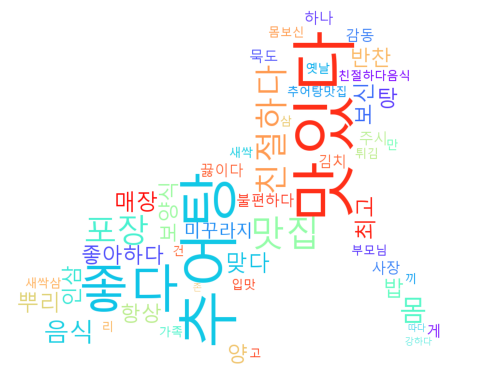

In [21]:
show_image(data.loc[data['대분류'] == '먹기', 'wordcloud'].values[0])

In [22]:
data.loc[data['대분류'] == '먹기', 'wordcloud'].values[0]

'iVBORw0KGgoAAAANSUhEUgAAA8AAAAL9CAIAAABrJ5gLAADt/0lEQVR4nOzdZXwUVxcG8GdmJS6QAEGCuxcvLqVQqFN371t3o6WlCnWjTl2pUdpCkeIUd3dJSEiI6/rM+yEhurOW3Vl7/j8+TGbu3jmhNDl79sy9gizLICIiIiIi14j+DoCIiIiIKJgwgSYiIiIicgMTaCIiIiIiNzCBJiIictuNg+QbBzl/iMjFYb4LgIh8gQk0EREREZEbmEATERH5E2vJREGHCTQRERERkRuYQBMRERERuUHr7wCIiIgCmoP+CqVLX28UfBYOEfkfK9BERERERG5gBZqIiMgRlpOJqA5WoImIiIiI3MAKNBERkauO7cOy3+QD21CQAwCNmqBrP5xzudC6s78jIyIVMYEmIiJyzmbDD2/L//5c62R2OrLTsXKePPEaXHm/IPJjXaLwwASaiIjIua9nyivnQRAx9lKMuEBo2Q6yjMzjWPWnvHwuFv4Aq0W+/jF2SxOFBSbQRERETuzZiJXzoNHigdeFPsOqz7frhnbdhD7D8N5j8r+/YOA4dO2namB11tHj845E6mACTURE5MTSX2UAk65Hzey5St/hOO96/P0Vlv4id+1nJ4VlmksUYphAExEROXF4JwCMvEAx8R15gfD3V/LBneqFVIG5OJFfMIEmIiJyorQYAJJSFAdUXCottH+VaS5RiOEDw0RERE7ExgNAfrbigIpLMXEqxUNE/sUEmoiIyImOvQFg1V+y0oCKSx17qRYREfkTWziIiIicGHeZsGWFvOBbdO6DXmfXvbrjPyz4FgDGTPG8VaPOg4ZaHRKSkJiMiEhAgNmIkkIkNcMTH7IbhMj/mEATERE50WMQRl2ElfPw1kPy2CkYcYHQoi0AZBzD6r/kZb9DljDqQvQa4rU7Wi3Iy0JeVq2TZcVem5+IGoIJNBERkXM3Pino9PK/v+DfX/DvL3V7Oc65HNc87GFtmI8YEgUdJtBERET

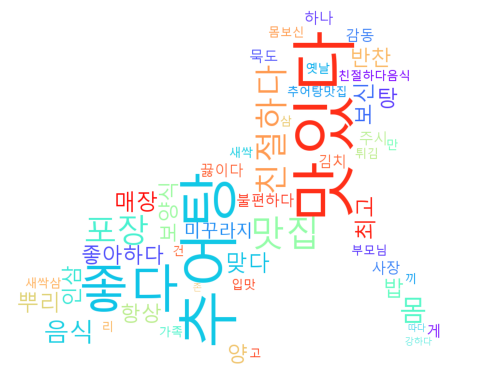

In [23]:
show_image(data.loc[data['대분류'] == '먹기', 'wordcloud'].values[0])

### Chroma DB 만들기 

In [24]:
from tqdm import tqdm

# # 데이터셋 벡터화
data['w2v_vector'] = data['keyword_extract'].apply(lambda x: weight_sentence_to_vector(x, W2V_MODEL))

# ChromaDB 클라이언트 초기화
client = chromadb.PersistentClient(path="./database/")
# client.delete_collection(name="ft_recommendation_db") # 이미 존재한다면 실행 또는 database 폴더전체 삭제하기
# FastText 벡터 컬렉션 생성 (이미 생성되어 있다고 가정)
ft_collection = client.get_or_create_collection(name="recommendation_chroma_db")

# 데이터셋을 순회하며 각 행의 키워드를 평균 벡터로 변환하여 ChromaDB에 추가
for index, row in tqdm(data.iterrows(), total=len(data)):
    ft_collection.add(
        ids = [str(index)],
        embeddings=row['w2v_vector'].tolist(),
        metadatas={
            'content': row['콘텐츠명'],  # 콘텐츠명을 메타데이터로 추가
            'gu_name': row['구명'],
            'large_category': row['대분류'],
            'medium_category': row['중분류'],
            'new_address': row['새주소[도로명 주소]'],
            'old_address': row['지번주소'],
            'longitude': row['좌표[X]'],
            'latitude': row['좌표[Y]'],
            'tel_number': row['전화번호'],
            'opening_hours': row['영업시간'],
            'parking_available': row['주차가능여부'],
            'facility_introduction': row['시설소개'],
            'naver_review_cnt': row['naver_review_cnt'],
            'kakao_review_cnt': row['kakao_review_cnt'],
            'positive_keyword': row['positive_keyword'],
            'ai_score': row['ai_score'],
            'review_cnt_for_ai_score': row['review_cnt_for_ai_score'],
            'wordcloud_img_arr': row['wordcloud'],
        }
    )

100%|██████████| 1562/1562 [00:11<00:00, 139.58it/s]


In [ ]:
user_input_data = ['강남구', '"아이들과 함께 갈 수 있는 좋은 키즈카페를 추천해줘요!"']
user_input_state = user_input_data[0]
user_input_sentence = input_process_text(user_input_data[1])
input_keywords = extract_keywords(user_input_sentence)
input_vectors = weight_sentence_to_vector(input_keywords, W2V_MODEL).reshape(1, -1)

In [ ]:
# 데이터 가져오기
get_database = ft_collection.get()
binary_category_pred = 0

# 데이터 필터링
filtered_binary_classification_idx = []
if get_database and 'metadatas' in get_database:
    for i, metadata in enumerate(get_database['metadatas']):
        if binary_category_pred == 0 and metadata.get('large_category') == '먹기':
            filtered_binary_classification_idx.append(get_database['ids'][i])
        elif binary_category_pred != 0 and metadata.get('large_category') != '먹기':
            filtered_binary_classification_idx.append(get_database['ids'][i])
            
# 입력 벡터를 사용하여 상위 결과를 쿼리
similarity_database = ft_collection.query(query_embeddings=input_vectors, n_results=100)

# Step 4: distances 가 5.0 보다 큰 것들은 제외
filtered_distances_idx = []
for idx, dist in enumerate(similarity_database['distances'][0]):
    if dist <= 5.0:
        filtered_distances_idx.append(similarity_database['ids'][0][idx])

filtered_threshold_database = ft_collection.get(ids = filtered_distances_idx)

# Step 5: 자치구 명이 사용자 입력 자치구 명과 동일한 것 상위에 보여주기
user_gu_name = "강남구"  # 사용자 입력으로 받은 자치구 명

same_gu_name_results = []
different_gu_name_results = []
for idx, result in enumerate(filtered_threshold_database['metadatas']):
    if result['gu_name'] == user_gu_name:
        same_gu_name_results.append({
            'id': filtered_threshold_database['ids'][idx],
            'metadata': result,
        })
    else:
        different_gu_name_results.append({
            'id': filtered_threshold_database['ids'][idx],
            'metadata': result,
        })

# 결과 병합: 동일 자치구 결과 + 다른 자치구 결과
sorted_results = same_gu_name_results + different_gu_name_results

### 워드클라우드 벡터db 접근 예제

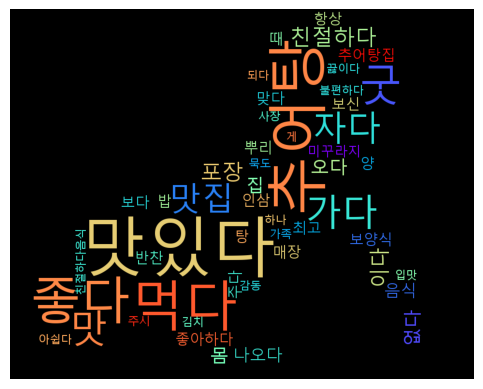

In [ ]:
show_image(ft_collection.get(ids='76')['metadatas'][0]['wordcloud_img_arr'])